In [19]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yaml
from logzero import logger
from tqdm import tqdm
from tqdm.notebook import tqdm
from yaml import dump, load, safe_load

In [2]:
sys.path.append("../../sql")
import queries

sys.path.append("../source")
import ts_tools

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [5]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [6]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "_" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [7]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [8]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['10514', '12309', '14031', '14534', '14817', '32312', '32317', '32424', '32605', '32606', '32653', '32803', '32828', '32927', '53005', '53092', '53217', '53597', '53719', '75022', '75035', '76904', '77059', '77062', '78002', '78039', '78504', '78733', '85045', '85253', '85286', '85747', '86032', '90272', '91011', '94024', '94127', '95973', '98029', '98177', '98607', '99337', '99338']


In [9]:
zipcode_index = -1
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
# df.head(5)

In [10]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [11]:
columns = df.columns.tolist()
print(columns, "\n")

['Clearsky_DNI', 'DNI', 'Clearsky_GHI', 'GHI', 'Temperature', 'Relative_Humidity', 'Precipitable_Water', 'Wind_Speed'] 



In [12]:
forecast_on_idx = 1
sarima_series = df_rsm[columns[forecast_on_idx]]

months, years = 12, 5
total_len = len(sarima_series)
test_len = months * years
train_len = total_len - test_len
print(f"train len: {train_len}, test_len: {test_len}")

train len: 216, test_len: 60


In [13]:
sarima_train = df_rsm.iloc[:train_len][columns[forecast_on_idx]]
display(sarima_train.tail())

sarima_test = df_rsm.iloc[train_len:][columns[forecast_on_idx]]
sarima_test.head()

date_time
2015-08-31    269.615591
2015-09-30    293.416667
2015-10-31    169.178763
2015-11-30    103.025000
2015-12-31     69.623656
Name: DNI, dtype: float64

date_time
2016-01-31    103.161290
2016-02-29    152.669540
2016-03-31    200.301075
2016-04-30    322.409722
2016-05-31    324.948925
Name: DNI, dtype: float64

In [14]:
sarima_order = ts_tools.gen_sarima_params(
    p_rng=(1, 1),
    d_rng=(1, 1),  # d cannot vary while using AIC
    q_rng=(1, 1),
    P_rng=(1, 1),
    D_rng=(1, 1),  # D cannot vary while using AIC
    Q_rng=(1, 1),
    debug=True,
)

SARIMA Order list length: 1
SARIMA Order list
 [(1, 1, 1, 1, 1, 1)]


In [15]:
results = ts_tools.SARIMA_optimizer(sarima_train, sarima_order, s=12, debug=False)
best_order = results.iloc[0]["(p, d, q, P, D, Q, s)"]

best_order

# (1, 1, 1, 1, 1, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 1, 1, 1, 1, 1)

In [16]:
model = ts_tools.sarima_model(
    sarima_train,
    *best_order,
    s=12,
    summary=True,
)

                                    SARIMAX Results                                     
Dep. Variable:                              DNI   No. Observations:                  216
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -991.883
Date:                          Wed, 04 Aug 2021   AIC                           1993.765
Time:                                  14:24:44   BIC                           2010.331
Sample:                              01-31-1998   HQIC                          2000.467
                                   - 12-31-2015                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0742      0.074     -1.006      0.315      -0.219       0.070
ma.L1         -0.9977      0.174     -5.726      0.

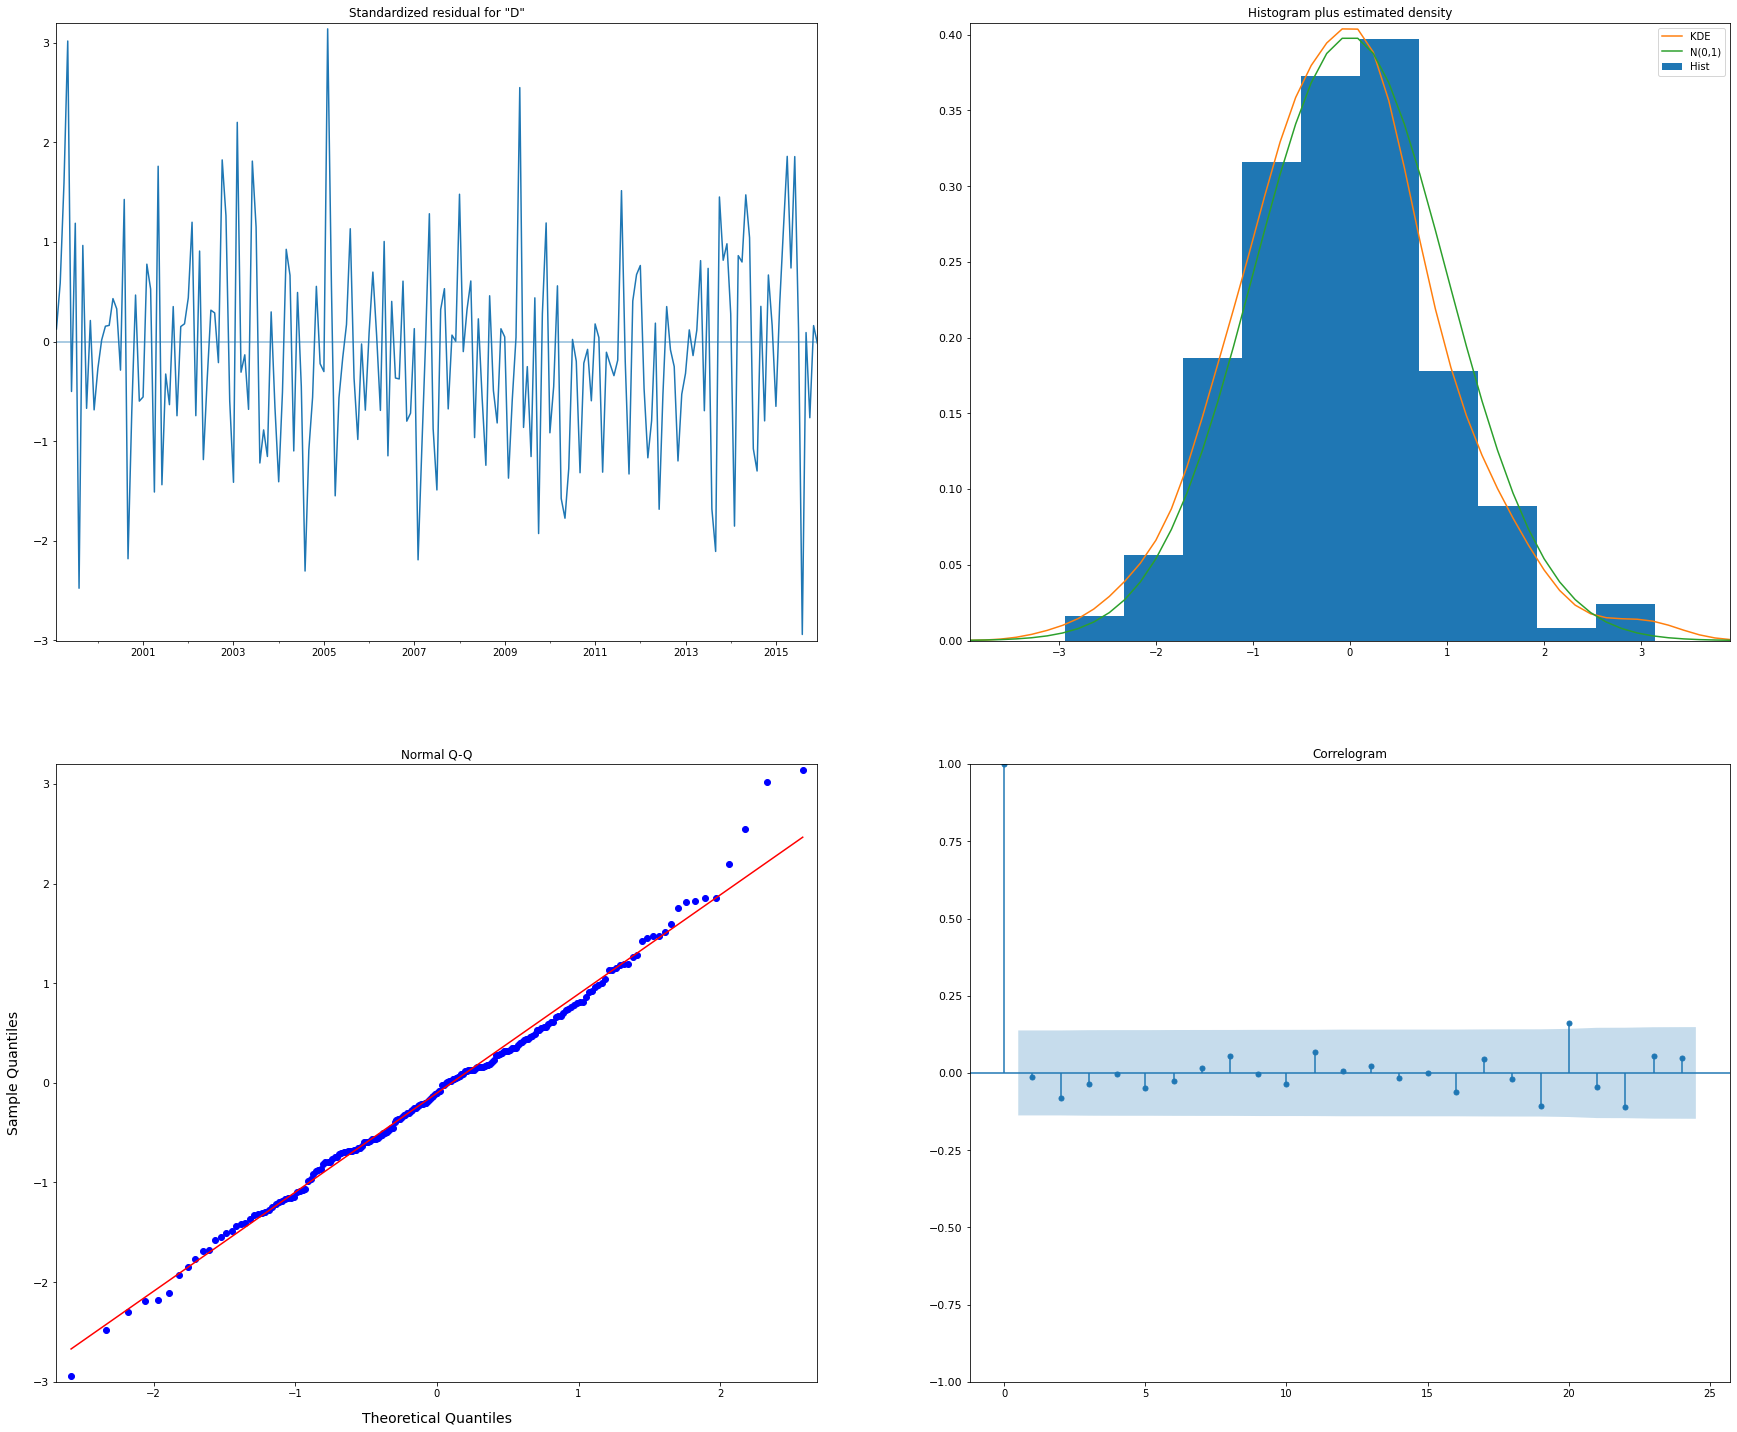

In [17]:
model.plot_diagnostics(lags=24);

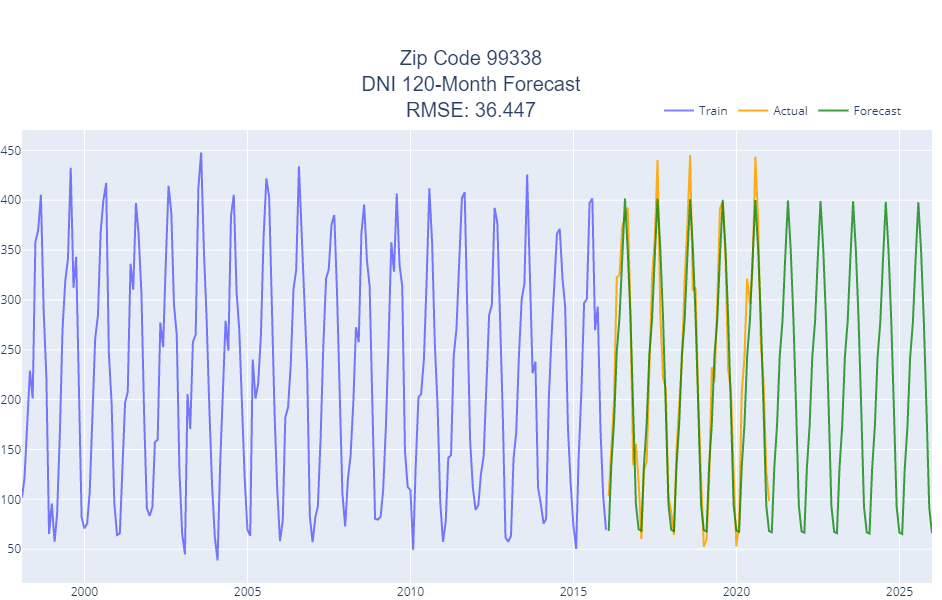

In [63]:
forecast = ts_tools.sarima_model(
    sarima_train,
    *best_order,
    s=12,
    num_fc=119,
    forecast=True,
)

actual = sarima_test
rmse = np.sqrt(np.mean((forecast - actual) ** 2))

data_names = ("Train", "Actual", "Forecast")
data_streams = [sarima_train, actual, forecast]

colors = (("blue", 0.5), ("orange", 0.9), ("green", 0.75))

fig = go.Figure()

columns[forecast_on_idx]

for idx, data in enumerate(data_streams):
    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data,
            opacity=colors[idx][1],
            mode="lines",
            name=data_names[idx],
            line=dict(color=colors[idx][0], width=2),
            connectgaps=True,
        )
    )

fig.update_layout(
    title=dict(
        text=(
            f"Zip Code {distinct_zipcodes[zipcode_index]}<br>{columns[forecast_on_idx]} {len(forecast)}-Month Forecast<br>RMSE: {rmse:0.3f}"
        ),
        xanchor="center",
        x=0.5,
        font=dict(
            family="Arial",
            size=20,
        ),
    ),
    title_pad=dict(
        t=0,
        b=0,
    ),
    autosize=True,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=0,
        t=130,
        pad=0,
    ),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.075,
        x=.70,
    ),
)

fig.show()